In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

from functions.Holt_Winters import Holt_Winters, timedataCVscore, plotHot_Winters


import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
df = pd.read_csv('../../data/preprocessed_data/train_oil_accum_without_gaps.csv')
df['MEASURED_IN_DATE'] = pd.to_datetime(df['MEASURED_IN_DATE'])
df.set_index('MEASURED_IN_DATE', inplace=True)
df.head()

,WELL_NAME,CHARWORK,WATER_CUT,P_ZAB,INTAKE,WELLHEAD_PRESSURE,LIQ_RATE,OIL_RATE,WATER_RATE,Q_LIQ_ACCUM,Q_OIL_ACCUM,Q_WATER_ACCUM
MEASURED_IN_DATE,,,,,,,,,,,,
2020-08-31,1,НЕФ,60.0,52.57,0.0,NaN,247.0,98.80,148.20,32268.0,18217.47,14050.53
2020-09-01,1,НЕФ,60.0,52.57,0.0,NaN,244.0,97.60,146.40,32512.0,18315.07,14196.93
2020-09-02,1,НЕФ,59.0,51.55,0.0,NaN,243.0,99.63,143.37,32755.0,18414.70,14340.30
2020-09-03,1,НЕФ,60.0,51.57,0.0,NaN,241.0,96.40,144.60,32996.0,18511.10,14484.90
2020-09-04,1,НЕФ,62.0,51.60,0.0,NaN,240.0,91.20,148.80,33236.0,18602.30,14633.70


In [6]:
test_size = 30
season_len = 30
data = df[df['WELL_NAME'] == 30]['LIQ_RATE']

test_data = data[- test_size : ]
train_data = data[: - test_size]
cv = 5

args = (train_data, cv)
bounds = ((0, 1), (0, 1), (0, 1))

best_score = np.inf

count_point = 100
pbar =  tqdm(total=count_point, desc='Search_params', colour='green')

for i in range(100):
    params_0 = [np.random.rand(), np.random.rand(), np.random.rand()]

    opt = minimize(fun=timedataCVscore, 
                   x0=params_0,
                   args=args,
                   method='TNC',
                   bounds=bounds
    )
    alpha, beta, gamma = opt.x
    model = Holt_Winters(data=train_data,
                     slen=season_len,
                     alpha=alpha, 
                     beta=beta, 
                     gamma=gamma,
                     n_preds=test_size,
                     scaling_factor=1.96)
    model.triple_exponential_smoothing()

    score = mean_squared_error(model.result[:- test_size], train_data)
    
    if score < best_score:
        best_alpha, best_beta, best_gamma = opt.x
        best_score = score
    pbar.update(1)
pbar.close()
        
print(best_alpha, best_beta, best_gamma)
print(f"лучший MSE = {best_score}")

Search_params: 100%|█████████████████████████████████████████████████████████████████| 100/100 [41:19<00:00, 24.79s/it]

0.8416616397126382 0.3363464181309441 0.9931562462713492
лучший MSE = 4.8731950382350915


<Axes: xlabel='MEASURED_IN_DATE'>

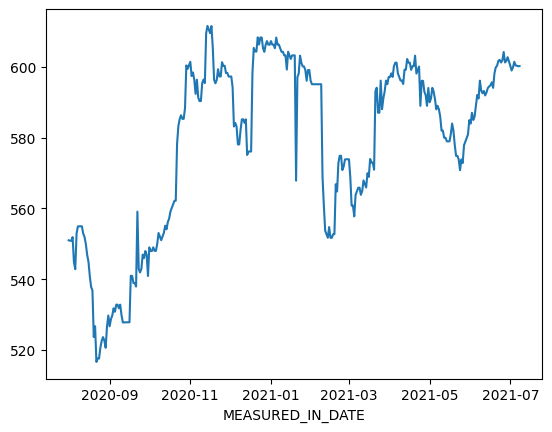

In [4]:
model = Holt_Winters(data=train_data,
                     slen=season_len,
                     alpha=best_alpha, 
                     beta=best_beta, 
                     gamma=best_gamma,
                     n_preds=test_size,
                     scaling_factor=1.96)
model.triple_exponential_smoothing()

answer = pd.Series(model.result, index=data.index)




sns.lineplot(answer)

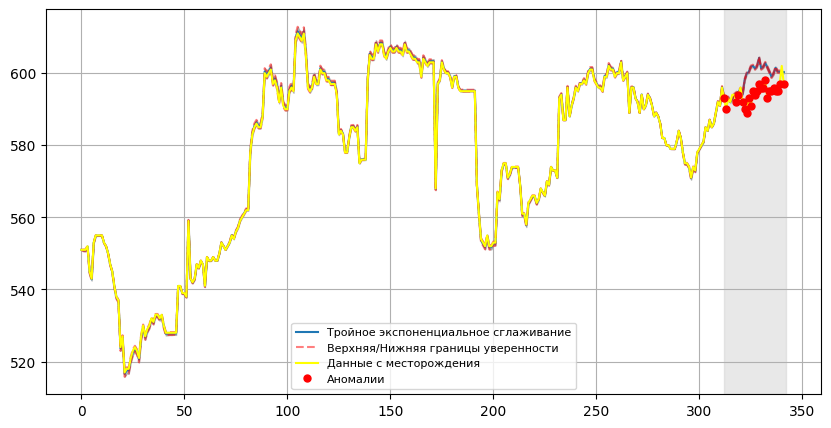

In [5]:
plotHot_Winters(model=model, 
                data=data,
                test_size=test_size)

In [26]:
def timedataCVscore_everymodels(data, model, cv, params: dict):
    '''
    Кросс-валидация на временных рядах
    data - столбец со значениями временного ряда
    model - модель, используемая для предсказания
    cv - количество разбиений в кросс-валидации
    params - dict c параметрами для запуска модели
    '''
    
    error = []
    
    values = data.values
    
    tscv = TimeSeriesSplit(n_splits=cv)
    
    for train, test in tscv(values):
        model = model(**params)
        model.fit(train)
        # Нужно сделать универсальную функцию для предсказания 
        model.predict(test)
        
        
        
        